In [22]:
# Using Joseph Bakarji's code 
!pip install pysindy

In [1]:
import numpy as np
import numpy.random as rng

from scipy.integrate import odeint


# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

from scipy import linalg

$$
\ddot{\phi}(t) = -\frac{g}{l} \sin(\phi(t))
$$

In [2]:
nsamples = int(20)
#m = np.random.uniform(1, 2, nsamples)

# basically repeating the simple pendulum experiment n times
# to get nsamples for the l and g values
m = np.random.uniform(1, 2, nsamples)
l = np.random.uniform(1, 2, nsamples)
g = 9.8+ np.random.random(nsamples)/100

# Stacking the arrays of l and g values on top of each other
P = np.vstack([m, l, g])

In [3]:
def rhs(y, p):
    # p is a pair of l and g values e.g. [1.78402421 9.80353984]
    # this means that l is 1.78402421
    # and g is 9.80353984
    m, l, g = p
#     print("this is p in rhs: {}".format(p))
#     print("this is y in rhs: {}\n".format(y))
    return np.array([y[1], 
                     (-g/l)*np.sin(y[0])])

def run_sim(p, phi0, t):
    '''
    The solution to the odeint function is an array with shape (500, 2). 
    The first column is the angle, and the second is the angular velocity. 
    '''
#     print("this is y in run_sim: {}".format(y))
#     print("this is phi0 in run_sim: {}".format(phi0))
    return odeint(lambda y, t: rhs(y, p), phi0, t) 


In [4]:
# run_sim(P[:, i], phi0[i, :], t)

In [5]:
'''
Took me a while to understand this but
phi0 is an array of the initial values for angle, i.e. phi, and the angular velocity, i.e. dphi
For initial conditions, we assume the pendulum is (nearly) vertical and (nearly) at rest.
'''
phi0 = 0.2*np.random.randn(nsamples, 2)

# 500 time values evenly spaced out from 0-10
t = np.linspace(0, 10, 500)  # Dimensional time
dt = t[1]-t[0]

# Initialises empty arrays
phi = np.zeros([nsamples, len(t)])
dphi = np.zeros([nsamples, len(t)])
ddphi = np.zeros([nsamples, len(t)])
for i in range(nsamples):
    y =  run_sim(P[:, i], phi0[i, :], t)
    phi[i, :] = y[:, 0]
    dphi[i, :] = y[:, 1]
    ddphi[i, :] = rhs(y.T, P[:, i])[1, :]

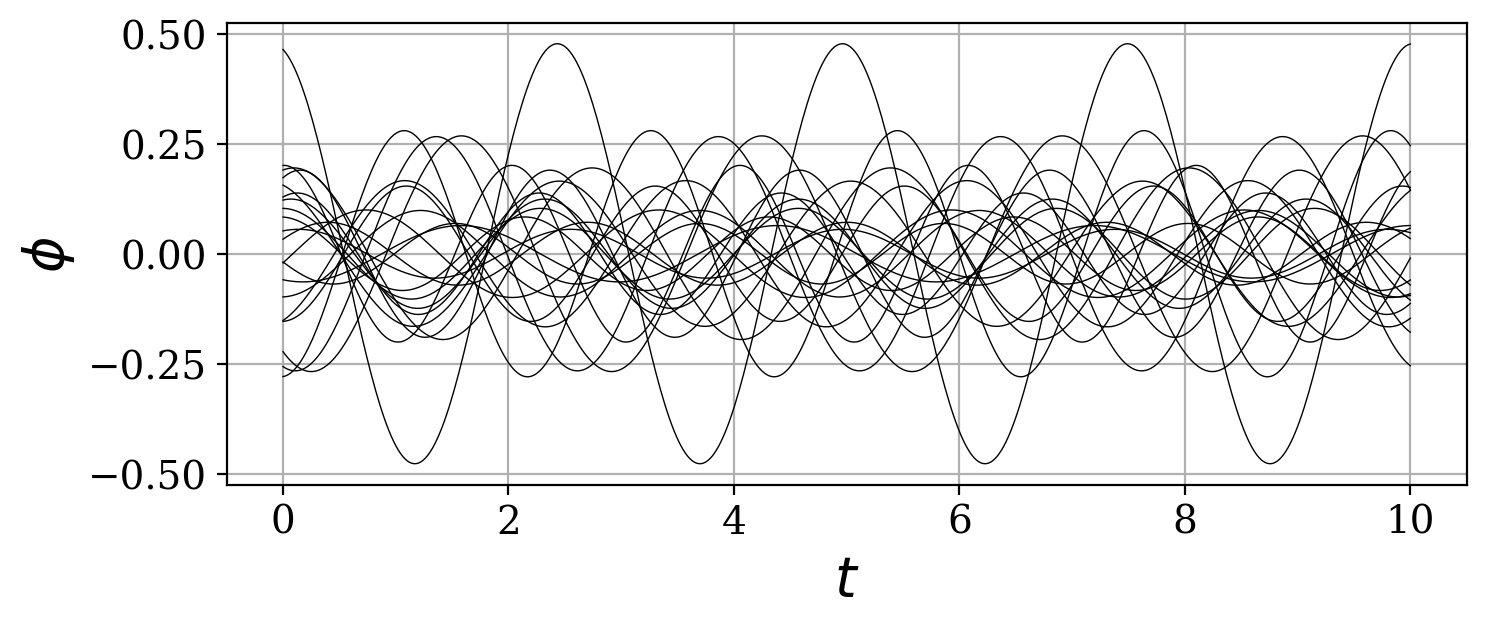

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(t, phi.T, c='k', lw=0.5)
plt.xlabel(r'$t$')
plt.ylabel(r"$\phi$")
plt.grid()
plt.show()

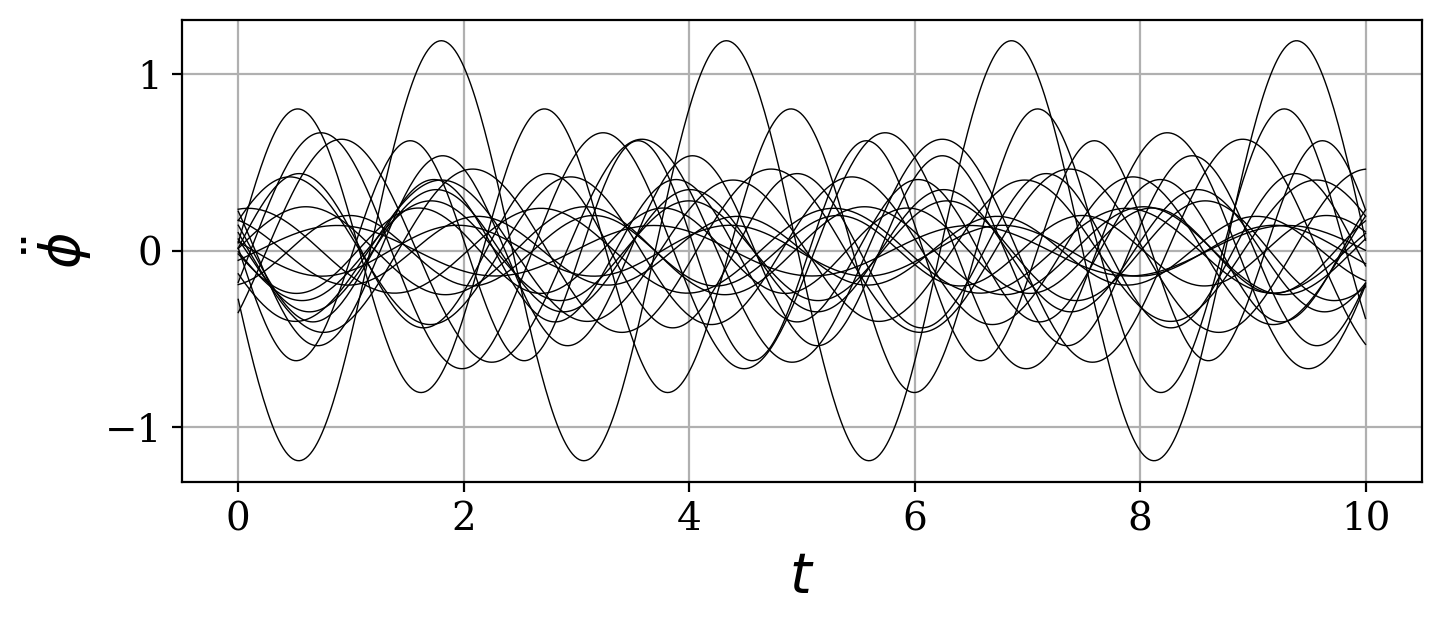

In [7]:
plt.figure(figsize=(8, 3))
plt.plot(t, dphi.T, c='k', lw=0.5)
plt.xlabel(r'$t$')
plt.ylabel(r"$\ddot{\phi}$")
plt.grid()
plt.show()

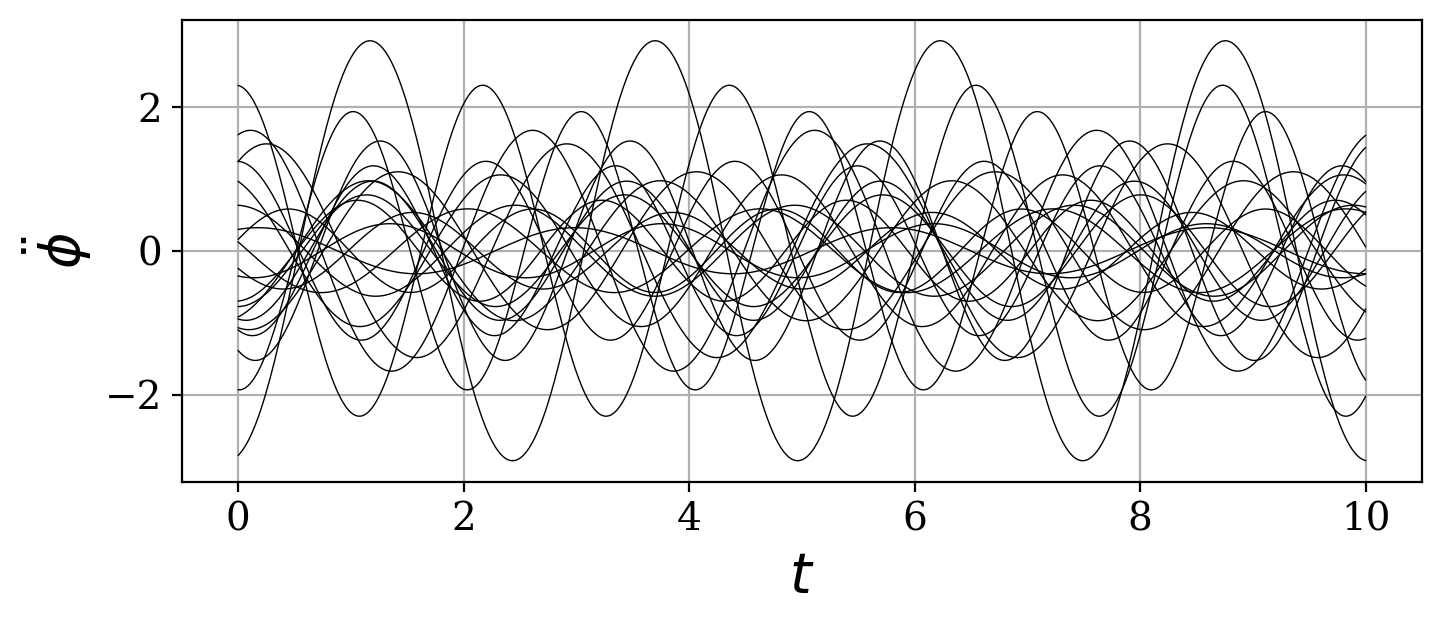

In [8]:
plt.figure(figsize=(8, 3))
plt.plot(t, ddphi.T, c='k', lw=0.5)
plt.xlabel(r'$t$')
plt.ylabel(r"$\ddot{\phi}$")
plt.grid()
plt.show()

## Nullspace search

In [9]:
from itertools import compress, product, combinations

from math import isnan, isinf


# Very inefficient
def is_collinear(v1, v2):
    # Return True if v1 and v2 are collinear vectors
    r = v1/v2
    x = []
    for i, ri in enumerate(r):
        if np.isfinite(ri) and abs(ri) > 0:
            x.append(ri)
    if len(x)>0 and not np.any(np.array(x)-x[0]):
        return True
    else:
        return False

def number_exists(num, nondim):
    # Return True if num (or a collinear to it) already exists in list 
    if not np.any(num):
        return True
    # Ignore collinearity here to avoid having to define more "p_fns"
    """for discovered in nondim:
        if is_collinear(num, discovered):
            return True"""
    return False


def get_nondim_numbers(dim_matrix, degree, num_params, time_vec=None):
    """
    Returns all possible dimensionless numbers in nullspace up to degree.
    
    If time_vec is included, should give the dimensions of time in dim_matrix rows
        e.g. [0, 0, 1]
        In this case, also returns all possible timescales
    """
    all_combinations = np.array(list(product(*[range(-degree, degree+1)] * num_params)))
    idxsort = np.argsort(np.sum(np.abs(all_combinations), axis=1))
    all_combinations = all_combinations[idxsort]
    nondim_list = []
    timescale_list = []
    for i in range(all_combinations.shape[0]):
        pi_candidate = all_combinations[i, :]
        if not np.any(dim_matrix @ pi_candidate):
            if not number_exists(pi_candidate, nondim_list):
                nondim_list.append(pi_candidate)
        elif (time_vec is not None) and (not np.any( dim_matrix @ pi_candidate - time_vec )):
            if not number_exists(pi_candidate, timescale_list):
                timescale_list.append(pi_candidate)
    return nondim_list, timescale_list


In [12]:
# Dimension matrix: [L, M, T] x [m, l, g]
D = np.array([[0, 1, 0], [1, 0, 0], [1, 0, -2]]).T

# Parameter matrix
P = np.vstack([np.repeat(m, len(t)),
               np.repeat(l, len(t)),
               np.repeat(g, len(t))]).T

time_vec = np.array([0, 0, 1])

nondim_list, timescale_list = get_nondim_numbers(D, 2, D.shape[1], time_vec=time_vec)

In [13]:
P.shape

(10000, 3)

In [15]:
len(t)

500

# pySINDy optimizer and sympy

In [16]:
import sympy as sym

# Define candidate functions
q_fns = [lambda q: q[1],
         lambda q: q[0],
         lambda q: q[0]**2,
         lambda q: q[0]**3,
         lambda q: q[0]**4,
         lambda q: q[0]**5,
         lambda q: q[0]**6,
         lambda q: q[0]**7
        ]

p_fns = [lambda pi: 1+0*pi[0],
         lambda pi: pi[0],
         lambda pi: pi[1]]

In [17]:
def Theta(Q, Pi):
    return np.vstack(
    [
        [
            q_fns[m](Q)*p_fns[n](Pi) for m in range(len(q_fns))
        ]
        for n in range(len(p_fns))  # Loops over this first, so first M functions are g[0]
    ]).T

In [19]:
q_sym = sym.symbols('m, l, g, \omega')

In [20]:
phi.shape

(20, 500)

In [23]:
import pysindy as ps

def fit_all_dynamics(nondim_list, timescale_list, num_nondim, threshold, verbose=False):
    from IPython.display import display, Math
    
    input_combinations = list(combinations(nondim_list, num_nondim))
    loss_list = []
    param_list = []
    param_names = []
    for T_vec in timescale_list:
        print(T_vec)
        Pi_t = np.exp( np.log(P) @ T_vec ).T  # Timescale
        
        # Quantity of interest scaled by time
        q = np.vstack([phi.flatten(), Pi_t*dphi.flatten()])
        dq =  (Pi_t**2*ddphi.flatten())[:, None]

        for pi_vecs in input_combinations:
            
            # Compute dimensionless parameters
            Pi = np.exp( np.log(P) @ np.vstack(pi_vecs).T ).T
            
            # Fit SINDy model
            opt = ps.STLSQ(threshold=threshold, alpha=0.0, max_iter=5)
            lib = Theta(q, Pi)
            opt.fit(lib, dq)
            test_loss = linalg.norm(dq - lib @ opt.coef_.T)

            # Save results
            loss_list.append(test_loss)
            
            # Save this parameter combination
            test_params = [sym.prod(q_sym**T_vec)]
            test_params.append([sym.prod(q_sym**pi_vec) for pi_vec in pi_vecs])
            param_names.append(test_params)
            param_list.append( (T_vec, pi_vecs) )
            if verbose:
                display(Math(sym.latex(test_params)))
                print('test loss = ', test_loss)
                print('----------------------------')
    return param_list, param_names, loss_list

In [28]:
threshold = 1e-2
num_nondim=2
param_list, param_names, loss_list = fit_all_dynamics(nondim_list, timescale_list, num_nondim, threshold)

In [29]:
from IPython.display import display, Math
sort_idx = np.argsort(loss_list)

print(loss_list)
for i in range(3):
    display(Math(sym.latex(param_names[sort_idx[i]])))
    print('test loss = ', loss_list[sort_idx[i]])
    print('----------------------------')

[]


IndexError: index 0 is out of bounds for axis 0 with size 0

Repeat for the best solution

In [15]:
model_idx = 0
T_vec = param_list[sort_idx[model_idx]][0]
pi_vec = param_list[sort_idx[model_idx]][1]

Pi_t = np.exp( np.log(P) @ T_vec ).T  # Timescale

# Quantity of interest scaled by time
q = np.vstack([phi.flatten(), Pi_t*dphi.flatten()])
dq =  (Pi_t**2*ddphi.flatten())[:, None]

# Compute dimensionless parameters
Pi = np.exp( np.log(P) @ np.vstack(pi_vec).T ).T

# Fit SINDy model
# Cubic terms
opt = ps.STLSQ(threshold=1e-1, alpha=0.00, max_iter=5)
lib = Theta(q, Pi)
opt.fit(lib, dq)
Xi3 = opt.coef_[0, :]

# Septic terms
opt = ps.STLSQ(threshold=5e-3, alpha=0.00, max_iter=5)
lib = Theta(q, Pi)
opt.fit(lib, dq)
Xi7 = opt.coef_[0, :]

In [16]:
lib = Theta(sym.symbols('q, \dot{q}'), sym.symbols('\pi_1, \pi_2')).flatten('F')
model = lib @ Xi3
model

-0.906460483010763*\dot{q}*\pi_1 + 0.146283918287287*\pi_1*q**3 - 0.920164192439404*\pi_1*q - 0.421360830407183*\pi_2*q**3 + 0.847784754751953*\pi_2*q